# Riskbook

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize, to_rgb
from matplotlib.cm import ScalarMappable

import risk_tool as rt

# Allow the plots to be interactive, for zooming and panning. Requires to install ipympl.
%matplotlib widget

- The risk data, in the form of colored maps, is retrieved from the [Risk Filter Suite](https://riskfilter.org/biodiversity/explore/map) website, using the `map_download.py` program. The maps are stored in the subdirectories of the “risk_maps” folder. Each subfolder contains the maps for a given risk category, and each map is stored as a `png` file. The "map.pgw" file contains the georeferencing information for the map, and is used by the `rasterio` package to display the map in the correct location. 

- The `risk_extraction.py` converts these map.png files, whose pixels are (r,g,b,a) values, into "risk_map.tif" files, whose pixels have values between 1 and 10 (and a mask for NA values).

- The `risk_tool.py` module is imported into the notebook (as `rt`), and contains key functions and objects.
    - **`rt.Riskmap`** objects are associated with a risk map for a single risk type. They contain useful methods for plotting, and for extracting the risk value at a given location.
    - **`rt.Regionmap`** objects are created when calling `get_region` on a `Riskmap` object. This calculates the risk map for one region, such as a country.

## Load and display risk colordata

### Global map

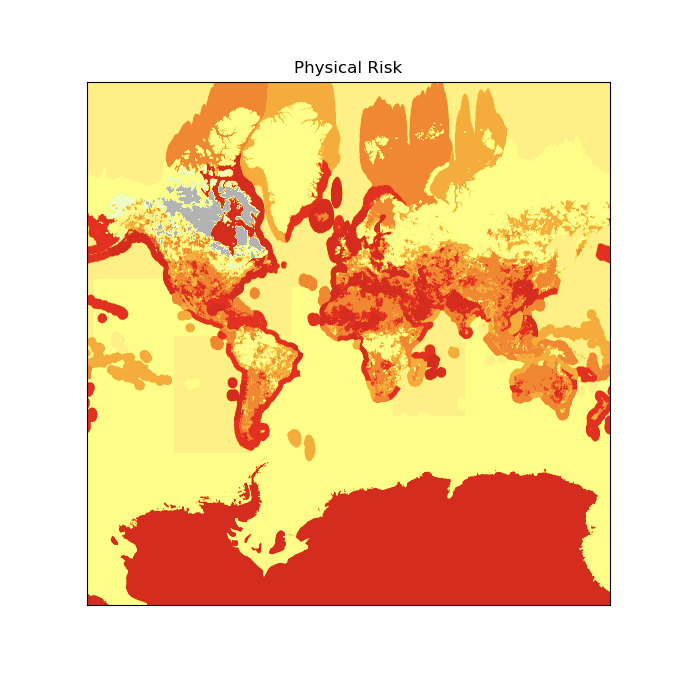

In [12]:
risk_type = "Physical Risk"
map_image_path = f"risk_maps/{risk_type}/risk_map.tif"
riskmap = rt.Riskmap(map_image_path)

fig, ax = plt.subplots(figsize=(6.8, 6.8))
ax.set(title=risk_type, xticks=[], yticks=[])
riskmap.plot(ax, cmap=rt.RISK_CMAP)
plt.show()

### Local map

To get country-specific data, we use data from [Natural Earth](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/), which allows us to create a geopandas DataFrame which contains country names, codes and geometries. This can be used to create a `Regionmap` object, from which country data can be retrieved.

In [13]:
countries = rt.load_shapefile("ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
countries = countries[countries["ADMIN"] != "Antarctica"]  # Remove Antarctica
countries.head()

,ADMIN,SOVEREIGNTY,SOV_A3,geometry
0,Zimbabwe,Zimbabwe,ZWE,"POLYGON ((3482952.052 -2559865.185, 3472863.72..."
1,Zambia,Zambia,ZMB,"POLYGON ((3383677.678 -1763424.464, 3367490.69..."
2,Yemen,Yemen,YEM,"MULTIPOLYGON (((5909466.918 1879933.508, 58533..."
3,Vietnam,Vietnam,VNM,"MULTIPOLYGON (((11584347.576 1163093.973, 1158..."
4,Venezuela,Venezuela,VEN,"MULTIPOLYGON (((-6770584.057 1021620.347, -678..."


#### Example: Germany

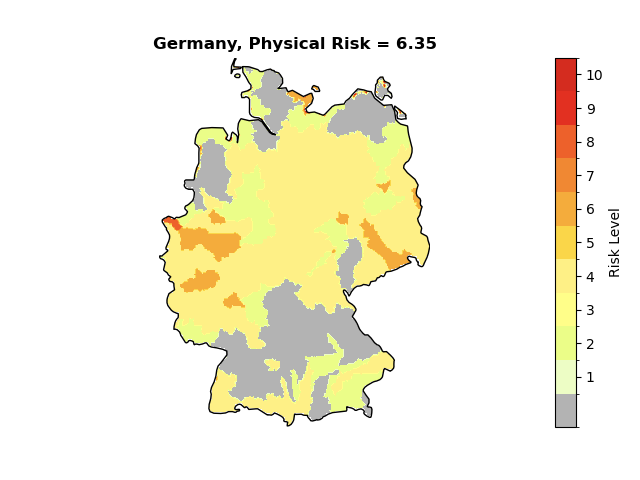

In [14]:
risk_type = "Pressures on Biodiversity"
risk_type = "Physical Risk"
riskmap = rt.Riskmap(f"risk_maps/{risk_type}/risk_map.tif")

germany_entry = countries.query(
    "ADMIN == 'Germany'"
)  # Make sure only Germany is in here
germany_regionmap = riskmap.get_region(germany_entry)
data = germany_regionmap.data

average_risk = np.mean(data)

fig, (ax, cax) = plt.subplots(1, 2, width_ratios=[1, 0.05])
ax.set(xticks=[], yticks=[])
# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)
germany_regionmap.plot(
    ax, title=f"Germany, {risk_type} = {average_risk:.2f}", cmap=rt.RISK_CMAP
)
rt.add_risk_colorbar(fig, cax)

## Multi-national analysis

The `risk_extraction.py` program was used to generate `risk_by_country.csv`, which contains the mean and standard deviation of each risk category of each country in the world.

In [15]:
risks = pd.read_csv("risk_by_country.csv", na_values="--")
risks.head()

,SOV_A3,SOVEREIGNTY,ADMIN,RISK_TYPE,RISK_MEDIAN,RISK_MEAN,RISK_STD,RISK_MAX,RISK_MIN
0,ZWE,Zimbabwe,Zimbabwe,Pressures on Biodiversity,4.0,4.590338,1.096382,9.0,2.0
1,ZMB,Zambia,Zambia,Pressures on Biodiversity,5.0,5.153135,1.415831,10.0,1.0
2,YEM,Yemen,Yemen,Pressures on Biodiversity,3.0,2.890509,1.101945,7.0,1.0
3,VNM,Vietnam,Vietnam,Pressures on Biodiversity,7.0,6.951889,1.235224,10.0,2.0
4,VEN,Venezuela,Venezuela,Pressures on Biodiversity,3.0,3.641431,0.797008,8.0,2.0


### Example: “Regulating services” risk in Scandinavia

,SOV_A3,SOVEREIGNTY,ADMIN,RISK_TYPE,RISK_MEDIAN,RISK_MEAN,RISK_STD,RISK_MAX,RISK_MIN
1067,SWE,Sweden,Sweden,Regulating Services - Mitigating,3.0,2.998228,0.177134,10.0,1.0
1107,NOR,Norway,Norway,Regulating Services - Mitigating,3.0,4.533004,1.765614,10.0,1.0
1159,ISL,Iceland,Iceland,Regulating Services - Mitigating,1.0,1.210906,0.894960,10.0,1.0
1176,FI1,Finland,Finland,Regulating Services - Mitigating,3.0,2.876421,0.514464,10.0,1.0
1189,DN1,Denmark,Denmark,Regulating Services - Mitigating,3.0,3.019553,0.755559,10.0,1.0


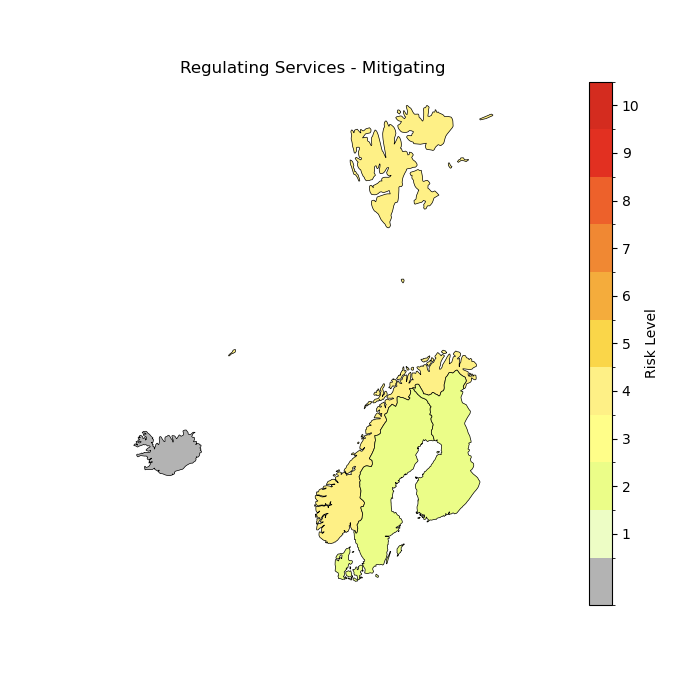

In [16]:
risks = pd.read_csv("risk_by_country.csv", na_values="--")
risk_type = "Regulating Services - Mitigating"

scandinavia = ("Norway", "Sweden", "Denmark", "Iceland", "Finland")
bio_risks = risks[risks["ADMIN"].isin(scandinavia)].query("RISK_TYPE == @risk_type")

display(bio_risks.head())

fig, (ax, cax) = plt.subplots(1, 2, width_ratios=(1, .05), figsize=(6.8, 6.8))
ax.set(xticks=[], yticks=[], title=risk_type)
# Remove spines:
for spine in ax.spines.values():
    spine.set_visible(False)
norm = plt.Normalize(vmin=1, vmax=10)
for country_name in scandinavia:
    country_entry = countries.query('ADMIN == @country_name')
    risk = bio_risks.query("ADMIN == @country_name  ")["RISK_MEAN"].item()
    country_entry.plot(ax=ax, fc=[rt.RISK_CMAP(norm(risk))], ec="black", lw=0.5)
rt.add_risk_colorbar(fig, cax)

### Example: “Biodiversity pressure” risk in Africa

Suppose you want to look at a continent, rather than countries. Then we need some dataset telling us which countries are in which continent, downloaded from [here](https://datahub.io/JohnSnowLabs/country-and-continent-codes-list) (saved as "countries_continents.csv").


In [17]:
countries_dataset = (
    pd.read_csv("countries_continents.csv")
    .rename(columns={"Three_Letter_Country_Code": "Country_Code"})
    .drop(columns=["Two_Letter_Country_Code", "Country_Number"]))
countries_dataset.head()

,Continent_Name,Continent_Code,Country_Name,Country_Code
0,Asia,AS,"Afghanistan, Islamic Republic of",AFG
1,Europe,EU,"Albania, Republic of",ALB
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),ATA
3,Africa,AF,"Algeria, People's Democratic Republic of",DZA
4,Oceania,OC,American Samoa,ASM


With this, we can filter the `risks` data down to countries in, for example, Africa.

,SOV_A3,SOVEREIGNTY,ADMIN,RISK_TYPE,RISK_MEDIAN,RISK_MEAN,RISK_STD,RISK_MAX,RISK_MIN
0,ZWE,Zimbabwe,Zimbabwe,Pressures on Biodiversity,4.0,4.590338,1.096382,9.0,2.0
1,ZMB,Zambia,Zambia,Pressures on Biodiversity,5.0,5.153135,1.415831,10.0,1.0
18,UGA,Uganda,Uganda,Pressures on Biodiversity,5.0,5.138084,1.602976,10.0,1.0
21,TUN,Tunisia,Tunisia,Pressures on Biodiversity,4.0,4.656625,1.524015,10.0,2.0
24,TGO,Togo,Togo,Pressures on Biodiversity,7.0,6.514880,0.874681,8.0,5.0


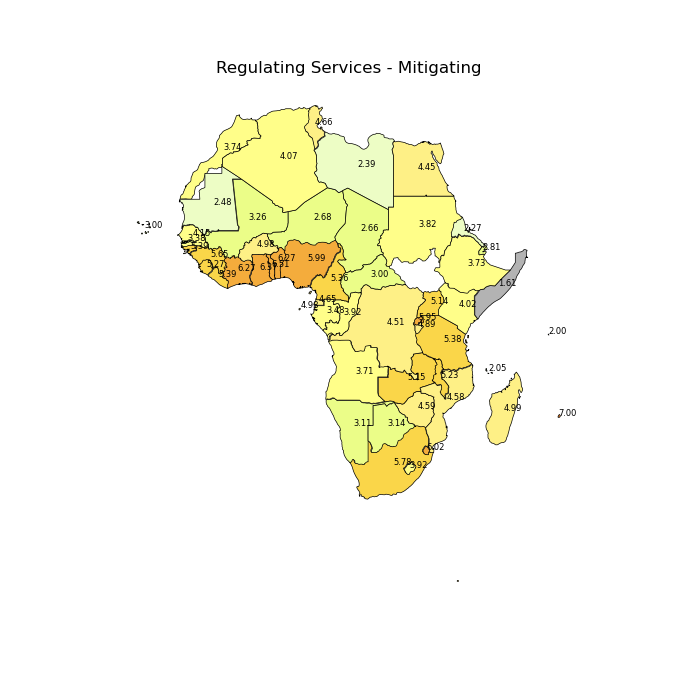

In [22]:
africa_countries = countries_dataset.query("Continent_Name == 'Africa'")
africa_countrycodes = africa_countries['Country_Code'].tolist()

africa_risks = risks.query("SOV_A3 in @africa_countrycodes")

display(africa_risks.head())

fig, ax = plt.subplots(figsize=(6.8, 6.8))
ax.set(xticks=[], yticks=[], title=risk_type)
for spine in ax.spines.values():
    spine.set_visible(False)

norm = plt.Normalize(vmin=1, vmax=10)
bio_risks = africa_risks.query('RISK_TYPE == "Pressures on Biodiversity"')
for country_code in bio_risks["SOV_A3"]:
    country_entry = countries.query('SOV_A3 == @country_code')
    risk_level = bio_risks.query('SOV_A3 == @country_code')["RISK_MEAN"].item()
    country_entry.plot(ax=ax, fc=[rt.RISK_CMAP(norm(risk_level))], ec="black", lw=0.5)

    centroid = country_entry["geometry"].item().centroid
    ax.annotate(f"{risk_level:.2f}", xy=[centroid.x, centroid.y], color="black", fontsize=6)

## Extracting risk at a geographic location

It is possible to query [OpenStreetMap](https://nominatim.openstreetmap.org/search) (an open source map) for latitude and longitude coordinates of a location. The location can be specified the way you search Google Maps, by an address, a store in a town, a landmark, etc. This functionality is implemented in the `Riskmap` object as the method `get_risk_at_addresses`, which takes a list of addresses and outputs a GeoDataFrame containing their risks and a `shapely.geometry.Point` object for each address. The latter can be used to plot the addresses on a map.

,address,risk,geometry
0,"Tromso, Norway",1,POINT (2110156.516 10956266.850)
1,"Barcelona, Spain",3,POINT (242390.644 5068983.532)
2,"Silicon Valley, USA",6,POINT (-13598179.287 4501035.975)
3,"Melbourne, Australia",3,POINT (16137226.624 -4553218.049)
4,"Siberia, Russia",3,POINT (11131949.079 8399737.890)
5,"Lima, Peru",8,POINT (-8575666.802 -1352777.343)
6,"Johannesburg, South Africa",10,POINT (3122480.770 -3024493.305)


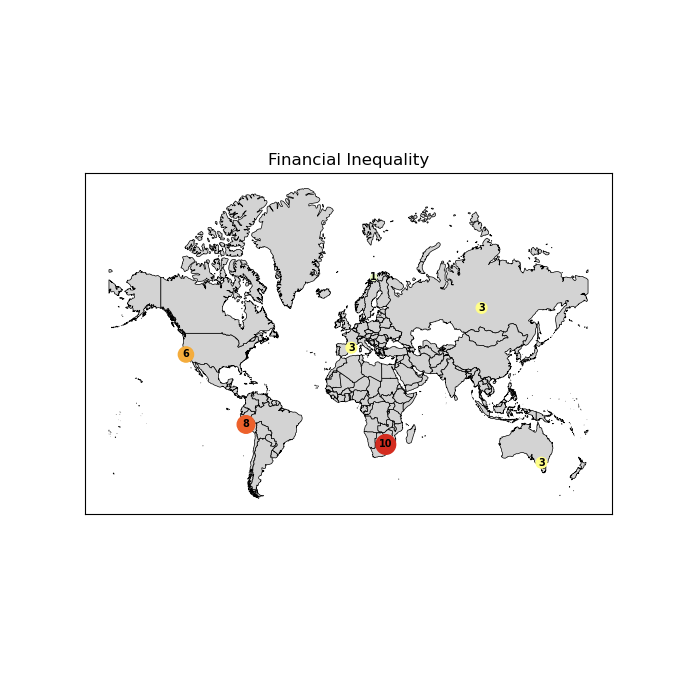

In [19]:
risk_category = "Financial Inequality"

riskmap = rt.Riskmap(f"risk_maps/{risk_category}/risk_map.tif")


address_list = [
    "Tromso, Norway",
    "Barcelona, Spain",
    "Silicon Valley, USA",
    "Melbourne, Australia",
    "Siberia, Russia",
    "Lima, Peru",
    "Johannesburg, South Africa",
]  # Can also be things like “Norrebro 39, 2039, Copenhagen, Denmark”

risks_locations = riskmap.get_risk_at_addresses(address_list)
display(risks_locations)

fig, ax = plt.subplots(figsize=(6.8, 6.8))
ax.set(xticks=[], yticks=[], title=risk_category)

countries.plot(
    ax=ax, color="lightgray", edgecolor="black", lw=0.5
)  # World map in the background

colors = [rt.RISK_COLORS[risk] for risk in risks_locations["risk"]]
risks_locations.plot(ax=ax, markersize=risks_locations["risk"] * 20, color=colors)

# Annotate each point with the risk value
for x, y, label in zip(
    risks_locations.geometry.x, risks_locations.geometry.y, risks_locations["risk"]
):
    ax.text(
        x, y, str(label), fontsize=7, ha="center", va="center", weight="bold"
    )

plt.show()